# Kumulipo

In [1]:
import re
from itertools import product
from functools import partial

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import fasttext
from umap import UMAP
from gensim.models import Phrases

from utils import multicore_apply

import warnings
from numba.errors import NumbaWarning
warnings.filterwarnings("ignore", category = UserWarning)
warnings.simplefilter("ignore", category = NumbaWarning)

In [2]:
def clean_line(line):
    line = line.replace('-', ' ')
    line = line.replace('á', 'ā').replace('ó', 'ō').replace('ì', 'ī')
    line = re.sub('[;",\[\]\?]', '', line)
    line = re.sub('\s{2,}', ' ', line)
    return line.lower().strip()

In [3]:
with open('../kumulipo.txt', 'r', encoding = 'utf-8') as f:
    kumulipo = []
    lines = f.read().strip().split("\n")
    for line in lines:
        kumulipo.append(
            clean_line(line.split(' ', 1)[-1])
        )

In [4]:
def phrase_model(lines, min_count, threshold, phrase_length):
    
    for _ in range(phrase_length):
        sentence_stream = [doc.split(" ") for doc in lines]
        bigram = Phrases(sentence_stream, min_count=min_count, threshold=threshold)
        lines = [' '.join(bigram[line.split()]) for line in lines]
        
    return lines

In [5]:
kumulipo = phrase_model(kumulipo, min_count = 30, threshold = 10, phrase_length = 5)

In [6]:
with open('../data/kumulipo_clean.txt', 'w', encoding = 'utf-8') as f:
    for line in kumulipo:
        f.write(line + '\n')

In [7]:
min_count = [1, 3, 5, 10, 20, 30, 50]
threshold = [1, 3, 5, 10, 20, 30, 50]

In [8]:
model = fasttext.train_unsupervised('../data/kumulipo_clean.txt', minCount = 1)

In [9]:
model_data = pd.DataFrame({'words': model.words})

In [10]:
model_data['word_vector'] = model_data.words.apply(model.get_word_vector)
model_data['word_vector'] = model_data['word_vector'] / model_data.word_vector.apply(np.linalg.norm)

In [11]:
word_vectors = np.vstack(model_data.word_vector.tolist())

In [12]:
similarity_matrix = np.dot(word_vectors, word_vectors.transpose())

In [13]:
word_counts = pd.Series([word for line in kumulipo for word in line.split()]).value_counts().to_frame().reset_index()
word_counts.columns = ['words', 'count']

In [14]:
n_neighbours = [2, 5, 10, 20, 50, 100, 200]
min_dist = [0.2, 0.4, 0.6, 0.8, 0.95, 0.99]

In [15]:
print("n_neighbors:", n_neighbours)
print("min_dist:", min_dist)

n_neighbors: [2, 5, 10, 20, 50, 100, 200]
min_dist: [0.2, 0.4, 0.6, 0.8, 0.95, 0.99]


In [16]:
def calculate_umap(params, umap_data, similarity_matrix):
    neighbors, dist = params

    reducer = UMAP(n_neighbors = neighbors, min_dist = dist)
    reduced = reducer.fit_transform(similarity_matrix)

    umap_data['n_neighbors'] = neighbors
    umap_data['min_dist'] = dist
    
    umap_data['x'] = reduced[:, 0]
    umap_data['y'] = reduced[:, 1]

    umap_data = umap_data[['n_neighbors', 'min_dist', 'words', 'x', 'y']].merge(word_counts, on = 'words', how = 'left')

    umap_data['rank'] = np.arange(len(umap_data))

    umap_data = umap_data[umap_data.words != '</s>']

    umap_data.columns = ['n_neighbors', 'min_dist', 'word', 'x_coord', 'y_coord', 'word_count', 'rank']

    return umap_data

In [17]:
word_vector_results = pd.concat(
    multicore_apply(
        product(n_neighbours, min_dist), 
        partial(calculate_umap, 
                umap_data = model_data,
                similarity_matrix = word_vectors))
)

100%|██████████| 42.0/42.0 [01:02<00:00, 1.49s/it]
42it [00:00, 105107.86it/s]


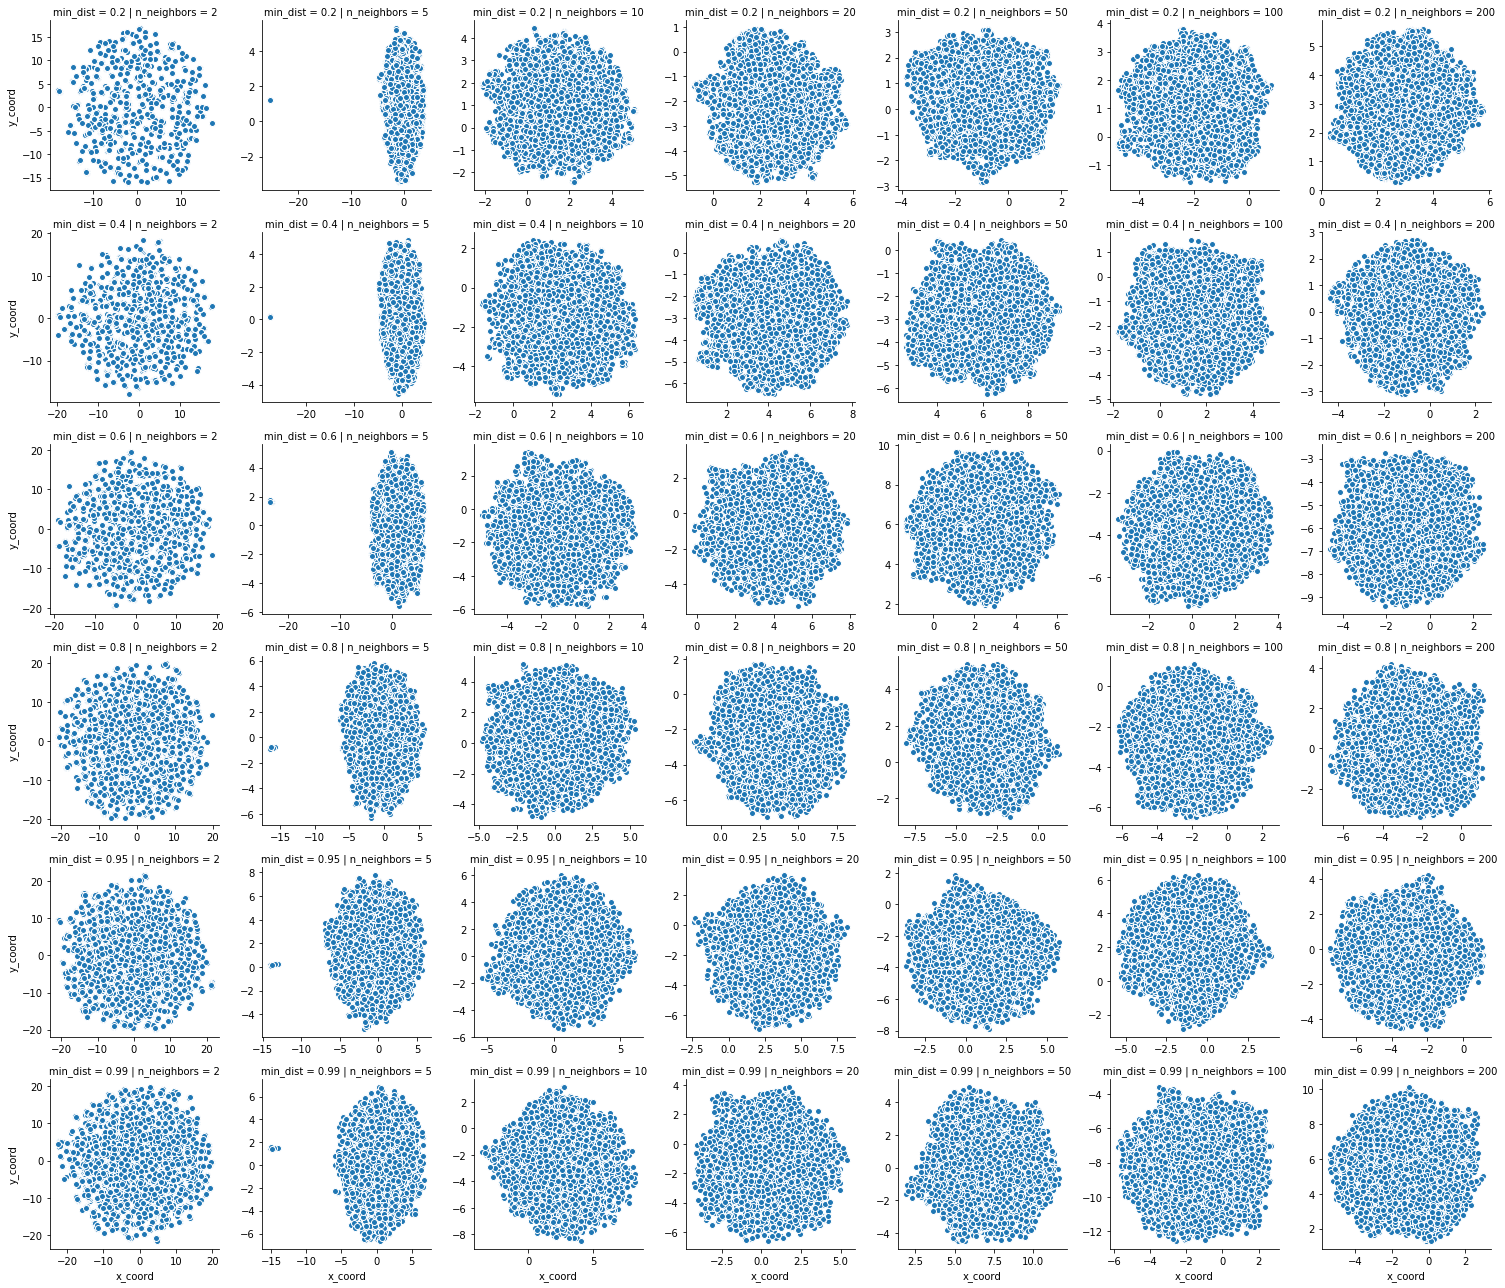

In [18]:
g = (sns.FacetGrid(word_vector_results, col="n_neighbors", row="min_dist", sharex = False, sharey = False)
    .map(plt.scatter, "x_coord", "y_coord", edgecolor="w")
)

In [19]:
similarity_matrix_results = pd.concat(
    multicore_apply(
        product(n_neighbours, min_dist), 
        partial(calculate_umap, 
                umap_data = model_data,
                similarity_matrix = similarity_matrix))
)

100%|██████████| 42.0/42.0 [01:12<00:00, 1.72s/it]
42it [00:00, 115363.96it/s]


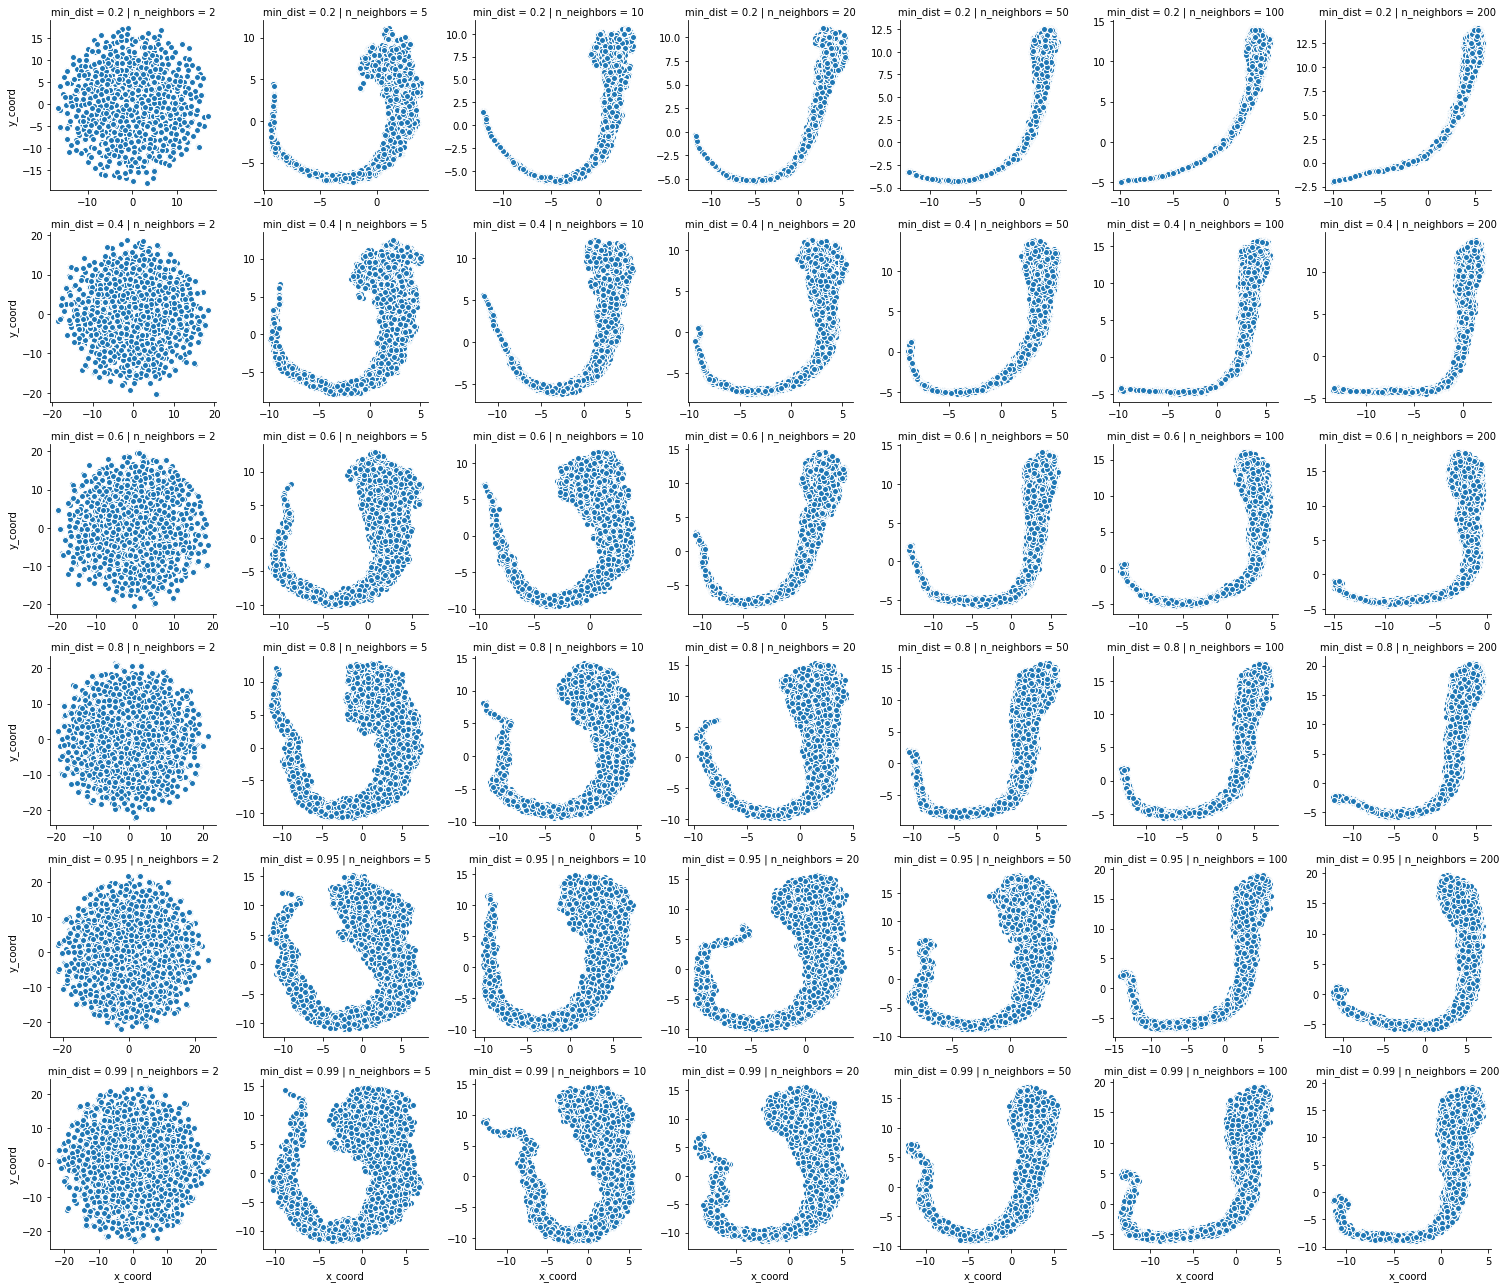

In [20]:
g = (sns.FacetGrid(similarity_matrix_results, col="n_neighbors", row="min_dist", sharex = False, sharey = False)
    .map(plt.scatter, "x_coord", "y_coord", edgecolor="w")
)